# 2.A. What to do with a `DynamicalSystem`? Orbit Diagram
An "orbit diagram" is simply a plot that shows the long term behavior of a discrete system when a parameter is varied. 

How does one compute it?
1. Evolves the system for a transient amount of time.
2. Evolves & saves the output of the system for a chosen amount of time.
3. Changes/increments a parameter of the equations of motion.
4. Repeat steps 1-3 for all given parameter values.

This is exactly what the function `orbitdiagram` does!


---

Let's make the super-ultra-famous orbit diagram of the logistic map:

$$x_{n+1} = rx_n(1-x_n)$$

In [7]:
using DynamicalSystems, Plots

In [2]:
logimap = Systems.logistic() # Systems module contains pre-defined well-known systems

1-dimensional discrete dynamical system
 state:       0.06725777339678096
 e.o.m.:      logistic_eom
 in-place?    false
 jacobian:    logistic_jacob
 parameters:  [4.0]

---

The call signature of `orbitdiagram` is:

```julia
orbitdiagram(discrete_system, i, p_index, pvalues; n, Ttr, ...)
```
* `i` is the index of the variable we want to save (for which variable to create the orbit diagram).
* `p_index` is the index of the parameter of `discrete_system` that we want to change.
* `pvalues` is the collection of the values that the changing parameter would take on.
* Keywords `Ttr` and `n` denote for how much transient time to evolve the system (that is, how many time steps to throw away from the beginning), and how many steps to save.


In [3]:
i = 1
n = 2000 # how many values to save
Ttr = 2000 # transient iterations
p_index = 1
pvalues = 2:0.001:4  # parameter values
output = orbitdiagram(logimap, i, p_index, pvalues; n = n, Ttr = Ttr)
typeof(output)

Array{Array{Float64,1},1}

* The output is a vector of vectors. Each inner vector has length `n` and contains the values of the `i`-th variable at the given parameter value.

---

Let's plot this!

In [4]:
function plot_od(r1, r2, n = 1000, Ttr = 1000)
    params = range(r1, stop = r2, length = 1001)

    res = orbitdiagram(logimap, 1, 1, params; n = n, Ttr = Ttr)
    L = length(params)

    x = Matrix{Float64}(undef, n, L)
    y = Matrix{Float64}(undef, n, L)
    for j in 1:L
        x[:,j] .= params[j]
        y[:,j] .= res[j]
    end
    scatter(x, y, 
        markersize=0.1, markeralpha = 0.3, markercolor="black",
        leg=false, title="Bifurcation graph", 
        html_output_format=:png, size=(2000,1000))
end

plot_od (generic function with 3 methods)

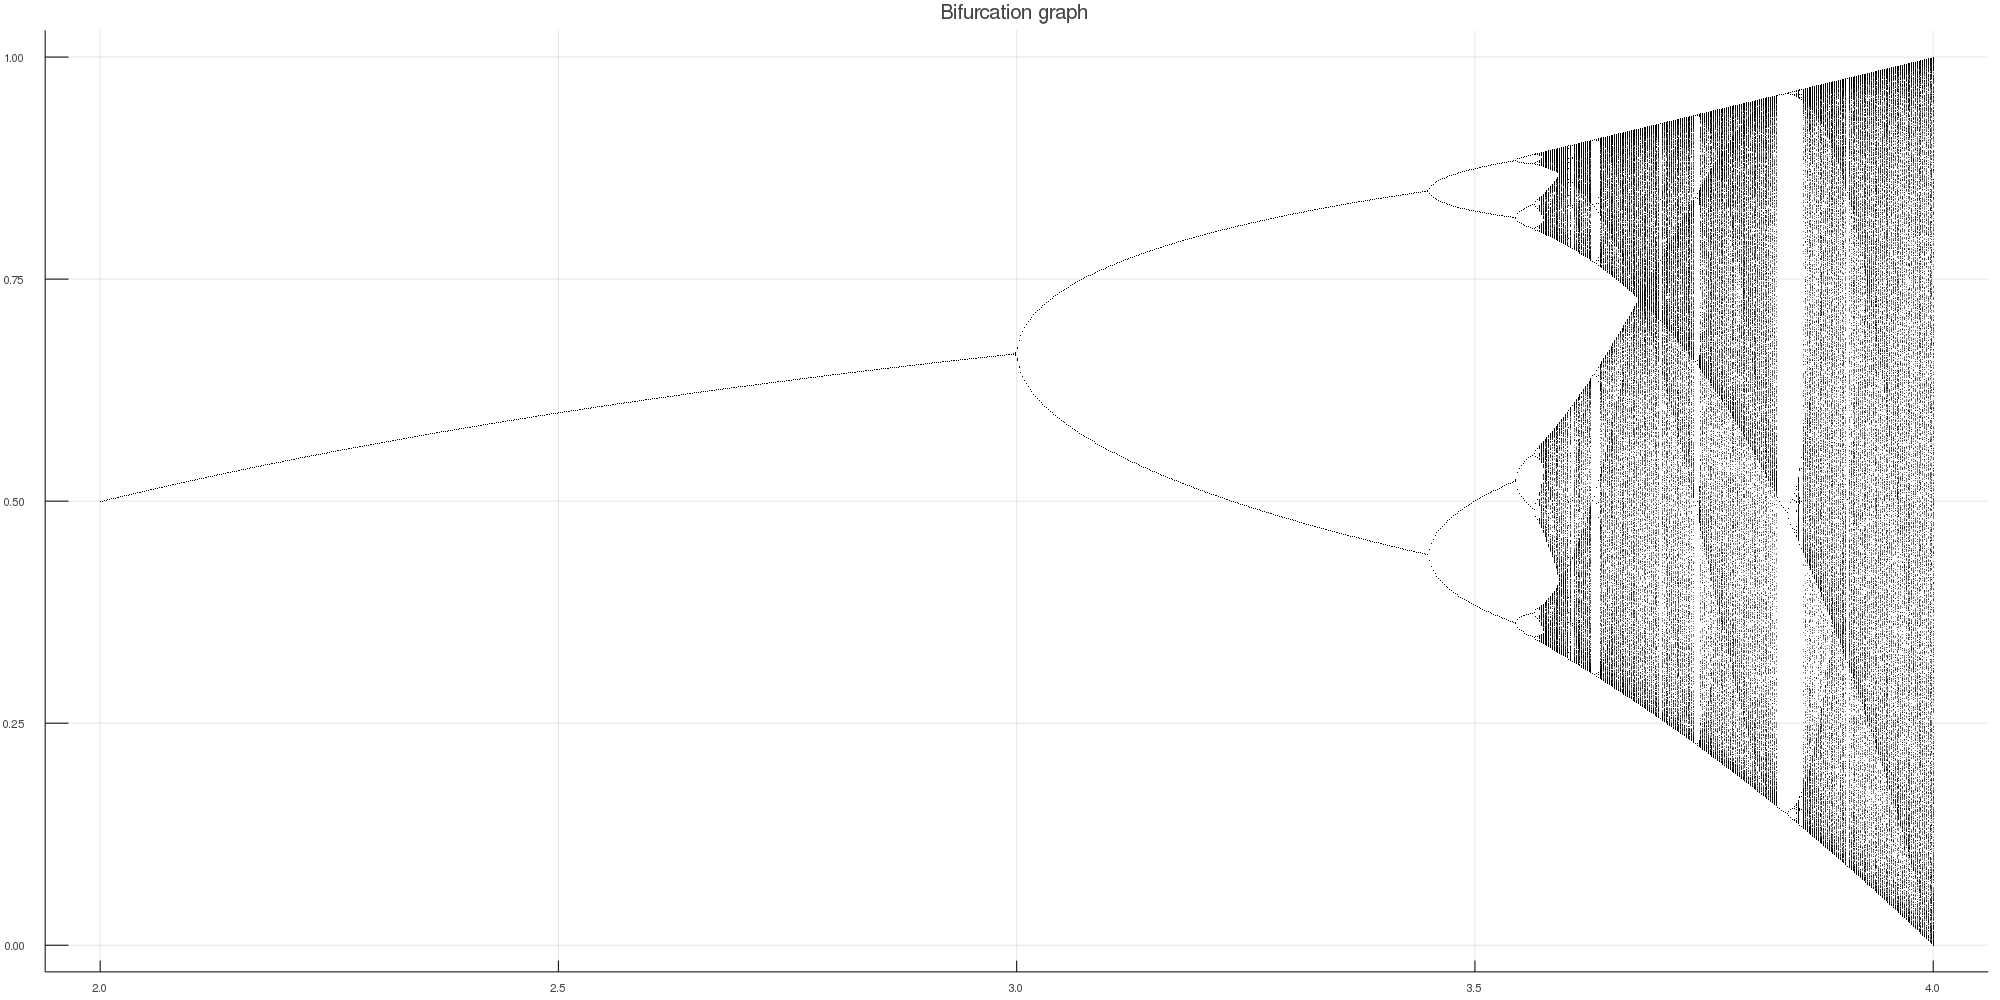

In [5]:
plot_od(2, 4.0)

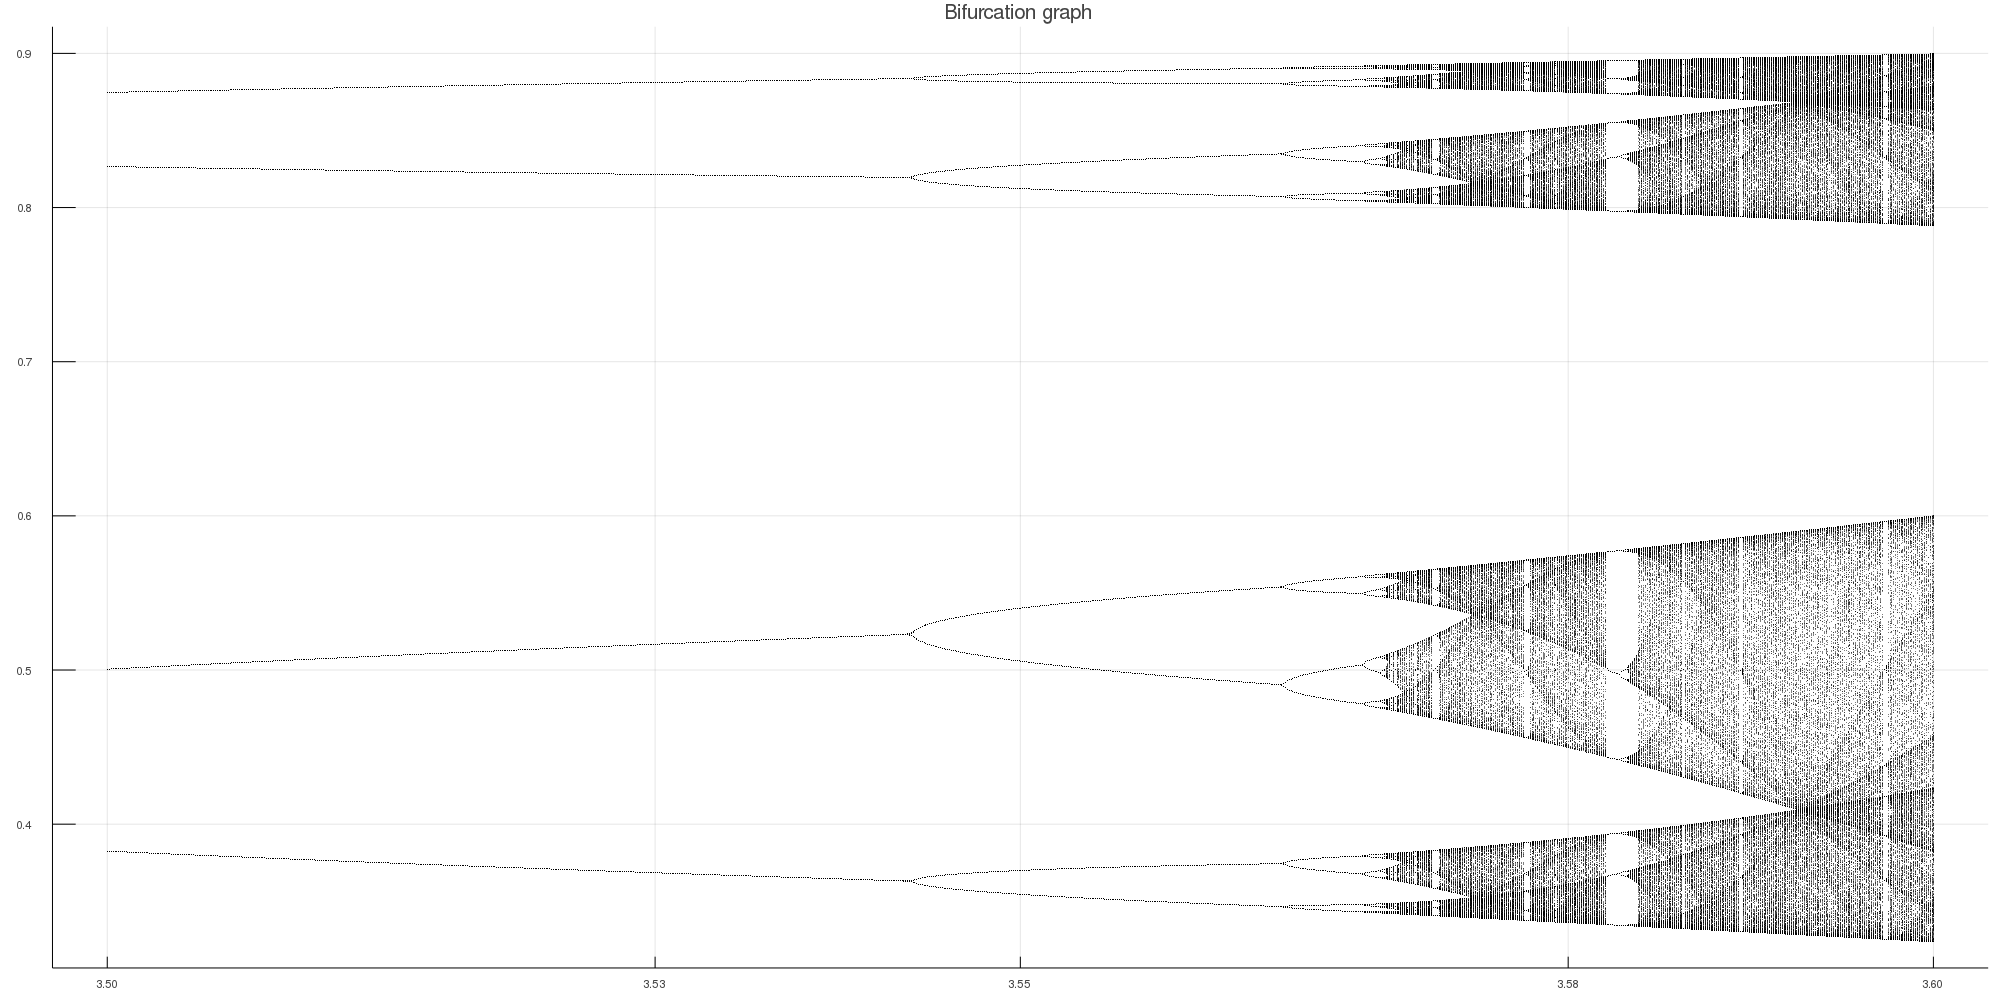

In [6]:
plot_od(3.5, 3.6)

---

* `orbitdiagram` works with *any* discrete system! Check out the [documentation page](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/orbitdiagram/) for more!

# 2.B. Poincaré Surface of Section
This is a technique to reduce a continuous system into a discrete map with 1 fewer dimension.
The wikipedia entry on [Poincaré map](https://en.wikipedia.org/wiki/Poincar%C3%A9_map) has a lot of useful info, but the technique itself is very simple:

1. Define a hyperplane in the phase-space of the system. 
2. Evolve the continuous system for long times. Each time the trajectory crosses this plane, record the state of the system.
3. Only crossings with a specific direction (either positive or negative) are allowed.

And that's it! The recorded crossings are the Poincaré Surface of Section!

## Defining a hyperplane
Let's say that our phase-space is $D$ dimensional. If the state of the system is $\mathbf{u} = (u_1, \ldots, u_D)$ then the equation for a hyperplane is 

$$
a_1u_1 + \dots + a_Du_D = \mathbf{a}\cdot\mathbf{u}=b 
$$
where $\mathbf{a}, b$ are the parameters that define the hyperplane.

---

Here is the call signature for a function that does this:

```julia
poincaresos(continuous_system, plane, tfinal = 100.0; kwargs...)
```
In code, `plane` can be either:

* A `Tuple{Int, <: Number}`, like `(j, r)` : the hyperplane is defined as when the `j`-th variable of the system crosses the value `r`.
* An `AbstractVector` of length `D+1`. The first `D` elements of the vector correspond to $\mathbf{a}$ while the last element is $b$. The hyperplane is defined with its formal equation.

---

As an example, let's see a section of the Lorenz system:
$$
\begin{aligned}
\dot{X} &= \sigma(Y-X) \\
\dot{Y} &= -XZ + \rho X -Y \\
\dot{Z} &= XY - \beta Z
\end{aligned}
$$


In [92]:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.6666666666666665]

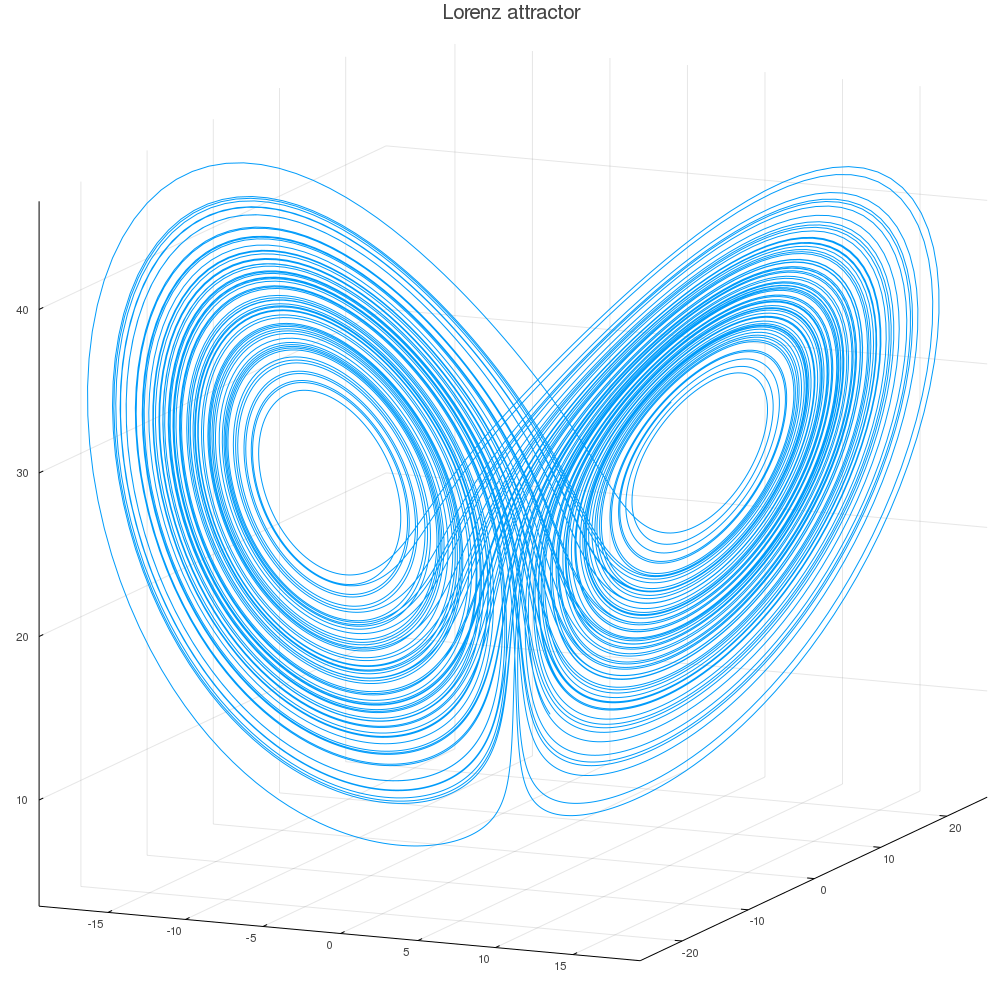

In [93]:
tr = trajectory(lor, 100.0, dt = 0.005, Ttr = 50.0)
x, y, z = columns(tr)
plot(x,y,z,
        leg=false, title="Lorenz attractor", 
        html_output_format=:png, size=(1000,1000))

**First, let's visualize the Poincaré Surface of Section in 3D**

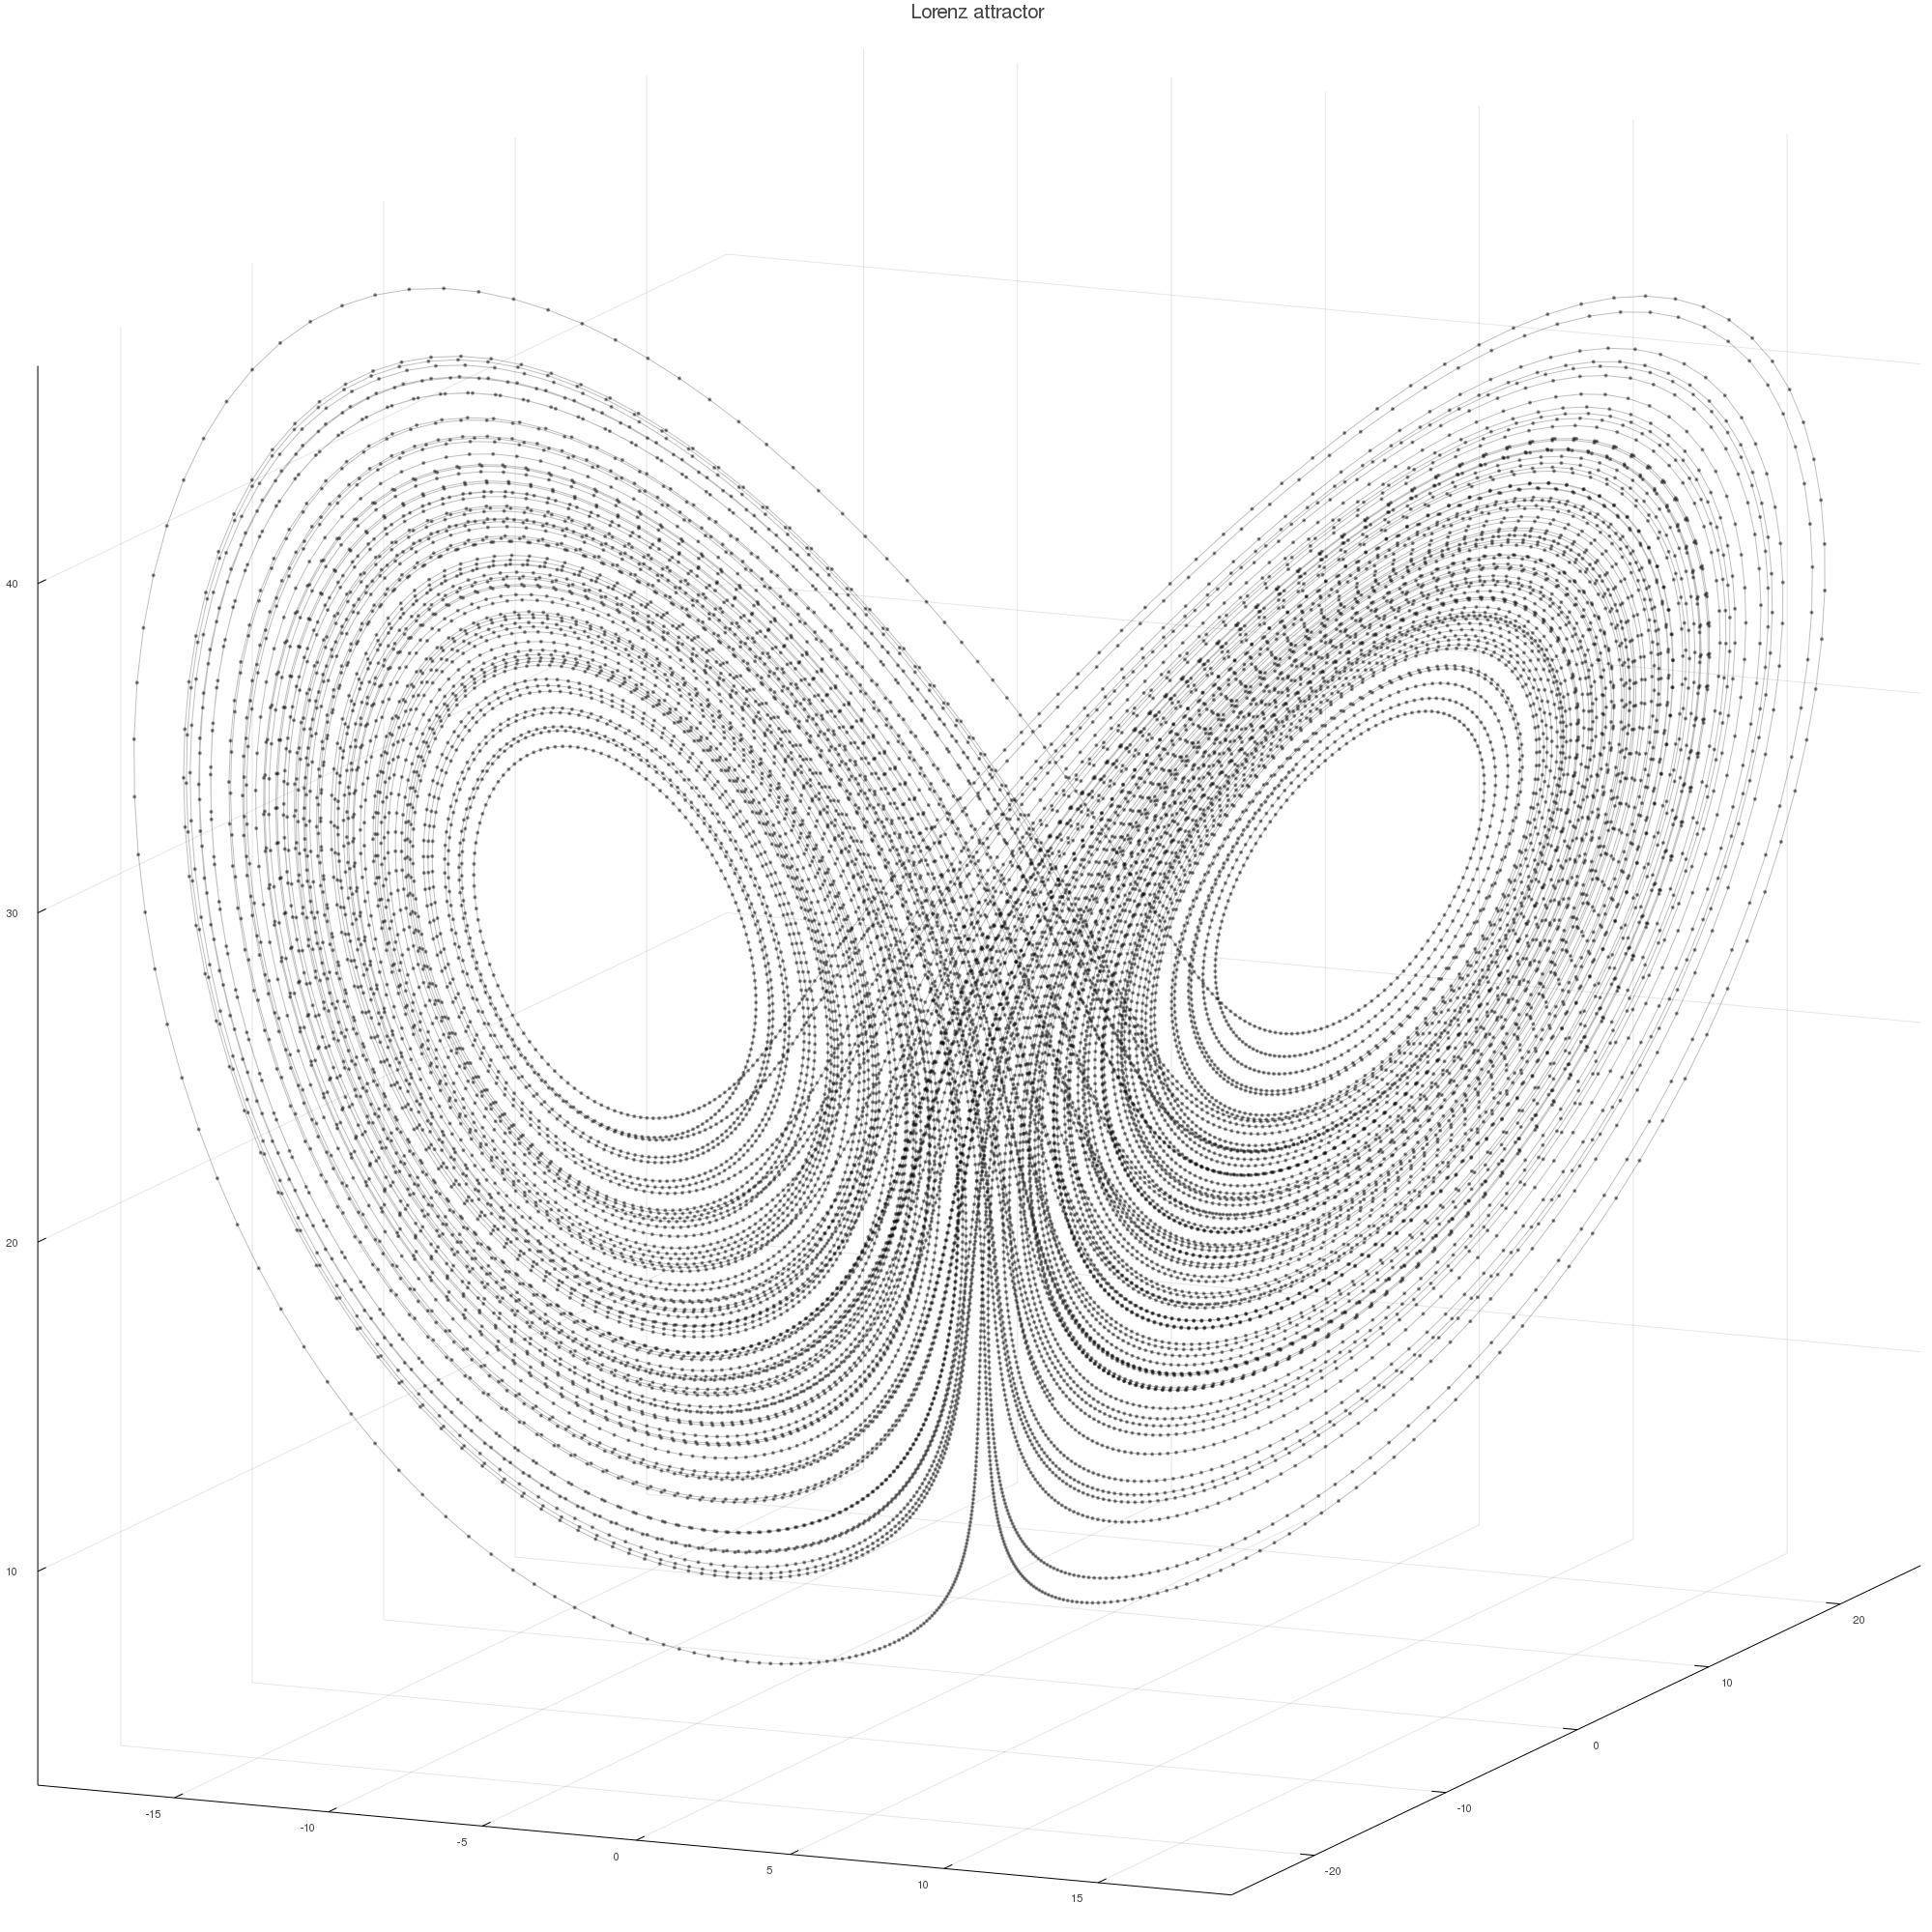

In [10]:
plot(x,y,z, color = :black, lw = 1, alpha = 0.25)
scatter!(x, y, z, 
        markersize=2, markeralpha = 0.4, markercolor="black",
        leg=false, title="Lorenz attractor", 
        html_output_format=:png, size=(2000,2000))

With the $y=0$ plane, we separate the attractor into for subsets: 
* points in the front, 
* points in the back, 
* points crossing the $y=0$ plane from the front,
* points crossing the $y=0$ plane from the back.

The `poincaresos` (Poincare surface of section) function would automatically find all points crossing the $y=0$ plane from the back to the front, which are drawn black in the following diagram.

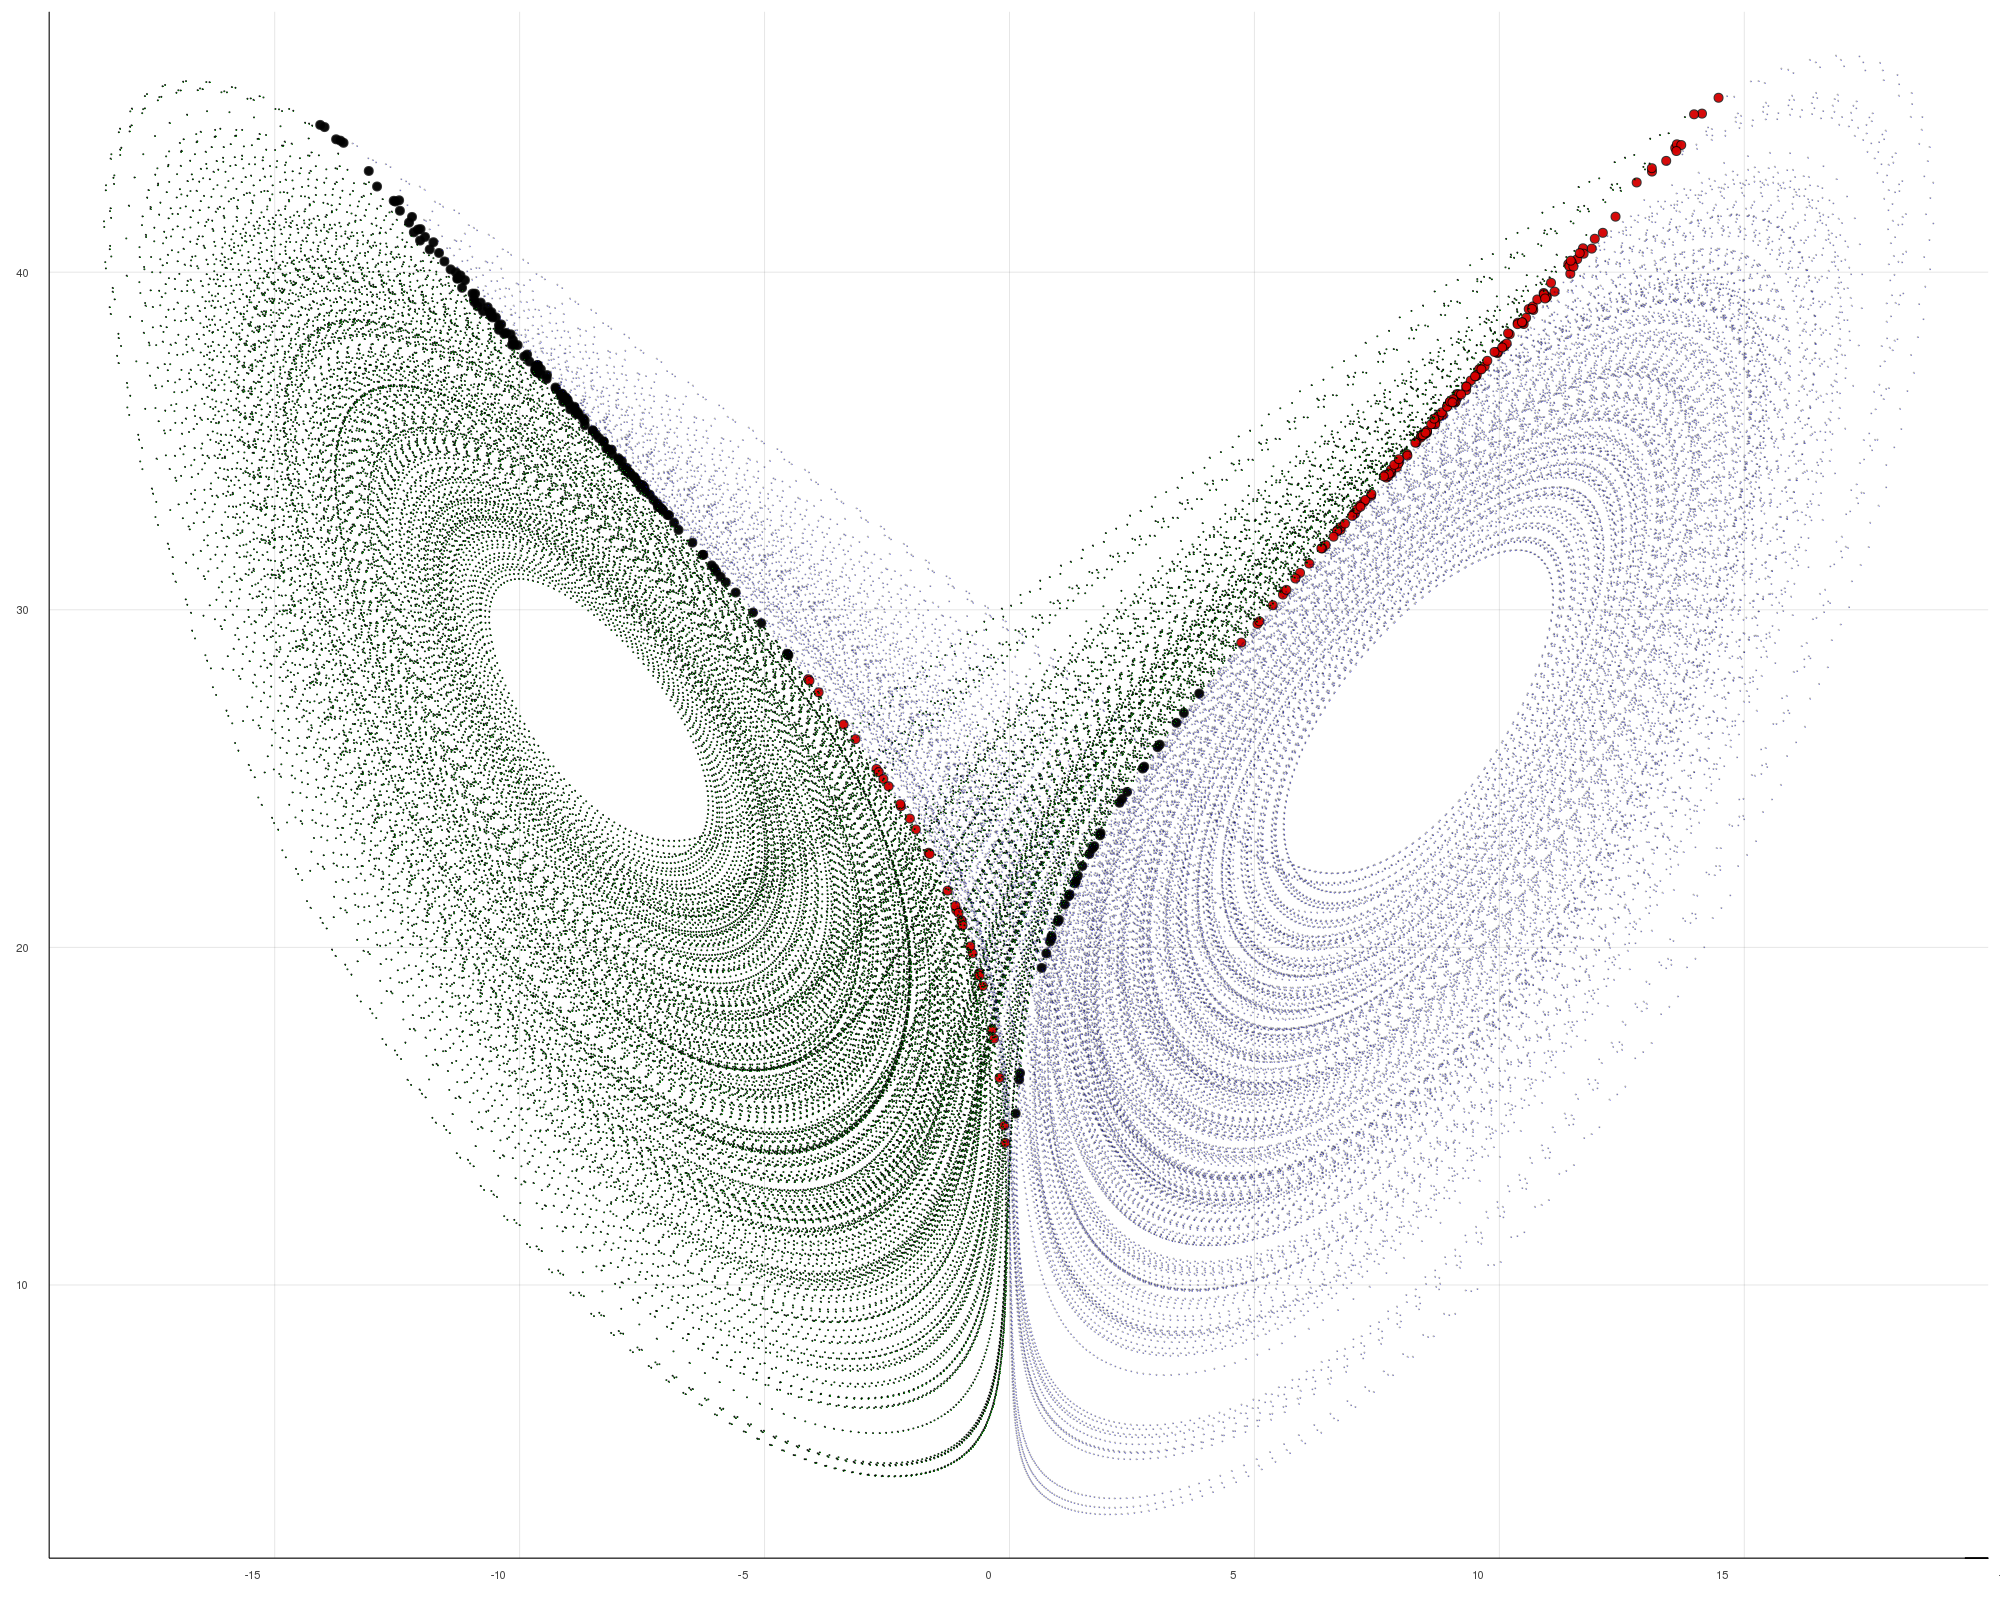

In [127]:
tr = trajectory(lor, 400.0, dt = 0.005, Ttr = 50.0)
x, y, z = columns(tr)

black = fill(false, length(y))
red = fill(false, length(y))
blue = fill(false, length(y))
green = fill(false, length(y))
for i in 1:length(y)-1
    if y[i] < 0 && y[i+1] > 0
        black[i] = true
    elseif y[i] > 0 && y[i+1] < 0
        red[i] = true
    elseif y[i] > 0
        blue[i] = true
    else
        green[i] = true
    end
end

scatter(x[black], y[black], z[black], 
        markersize=5, markeralpha = 0.8, markercolor=:black)
scatter!(x[red], y[red], z[red], 
        markersize=5, markeralpha = 0.8, markercolor=:red)
scatter!(x[green], y[green], z[green], 
        markersize=1, markeralpha = 0.9, markercolor=:green)
scatter!(x[blue], y[blue], z[blue], 
        markersize=1, markeralpha = 0.3, markercolor=:blue,
        leg=false,
        html_output_format=:png, size=(2000,1600), camera = (0,0))

**Now let's use the `poincaresos` function**

In [13]:
plane = (2, 0.0) # when 2nd variable crosses 0.0

(2, 0.0)

In [14]:
psos_chaotic = poincaresos(lor, plane, 2000.0, Ttr = 100.0)

3-dimensional Dataset{Float64} with 937 points
  -6.84084    -3.26833e-7   32.6236
 -10.9323     -1.51611e-8   39.4884
   2.42964     4.98167e-8   24.653 
  -7.48051    -2.16374e-7   33.6897
 -13.5586     -2.89842e-8   44.0752
 -12.2479      6.38744e-9   41.7609
   0.0820689  -7.76434e-10  14.0957
  -6.44293    -3.98101e-7   31.9586
 -10.2996     -5.97271e-10  38.4108
  -9.52617    -5.72668e-8   37.105 
 -12.9207      4.84257e-11  42.9422
   0.741676   -1.46593e-10  19.7543
  -6.42726    -3.95583e-7   31.9323
   ⋮                               
 -12.5787     -9.92325e-9   42.34  
 -12.32       -2.11224e-11  41.8868
   1.15626    -3.38947e-10  21.3312
  -6.41022    -3.25056e-7   31.9038
 -10.2561     -2.35591e-9   38.337 
  -9.1624     -7.75563e-10  36.4944
 -10.0302     -1.6222e-8    37.9547
   2.19418     1.83043e-8   24.1266
  -6.98386    -5.25592e-7   32.8626
 -11.227       2.84614e-9   39.9935
 -11.4022     -4.50491e-8   40.2947
   1.0579     -4.64854e-11  20.9966

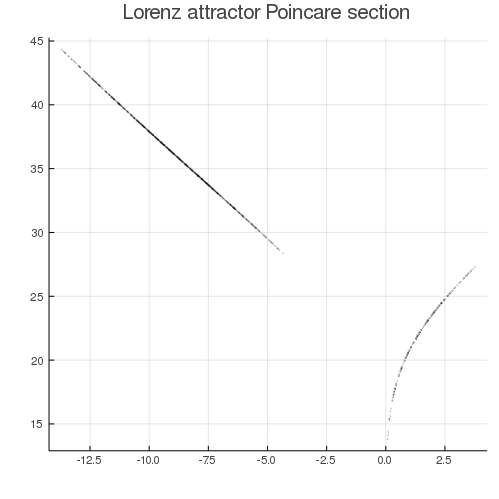

In [15]:
scatter(psos_chaotic[:, 1], psos_chaotic[:, 3],
        markersize=0.15, markeralpha = 0.15, markercolor=:black,
        leg=false, title="Lorenz attractor Poincare section", 
        html_output_format=:png, size=(500,500))

* We see that the surface of section is some kind of 1-dimensional object. 
* This is expected, because as we will show in the tutorial "Entropies & Dimensions" the Lorenz system (at least for the default parameters) lives in an almost 2-dimensional attractor.

* This means that when you take a cut through this object, the result should be 1-dimensional!

Let's now compute the PSOS for a parameter value where the Lorenz system is stable instead of chaotic:

In [84]:
set_parameter!(lor, 2, 69.75)

69.75

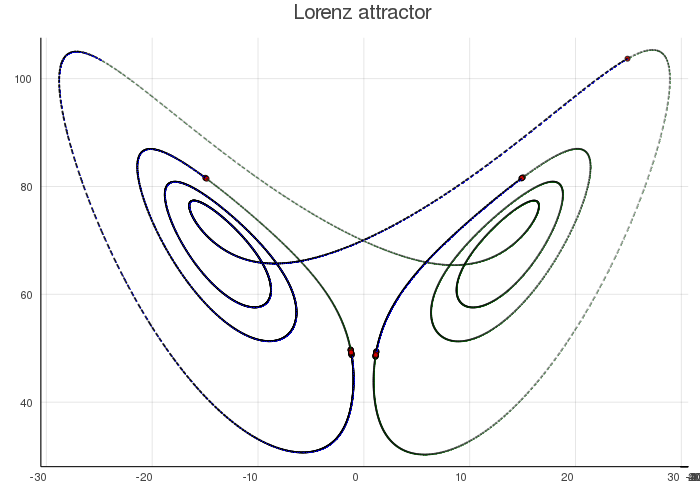

In [89]:
tr = trajectory(lor, 100.0, dt = 0.01, Ttr = 500.0)
x, y, z = columns(tr)
red = -0.1 .< y .< 0.1
blue = y .≤ -0.1
green = y .≥ 0.1;

scatter(x[red], y[red], z[red], 
        markersize=3, markeralpha = 0.8, markercolor=:red)
scatter!(x[green], y[green], z[green], 
        markersize=1, markeralpha = 0.3, markercolor=:green)
scatter!(x[blue], y[blue], z[blue], 
        markersize=1, markeralpha = 0.8, markercolor=:blue,
        leg=false, title="Lorenz attractor", 
        html_output_format=:png, size=(700,500), camera = (0,0))

In [86]:
psos_regular = poincaresos(lor, (2, 0.0), 2000.0, Ttr = 1000.0)
summary(psos_regular)

"3-dimensional Dataset{Float64} with 1710 points"

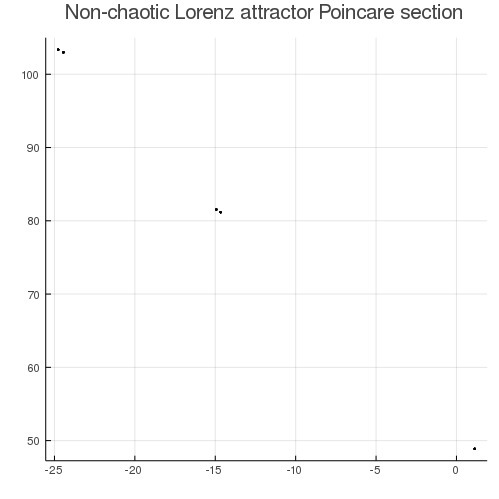

In [87]:
scatter(psos_regular[:, 1], psos_regular[:, 3],
        markersize=0.15, markeralpha = 0.15, markercolor=:black,
        leg=false, title="Non-chaotic Lorenz attractor Poincare section", 
        html_output_format=:png, size=(500,500))

And here are the two different PSOS plots side by side:

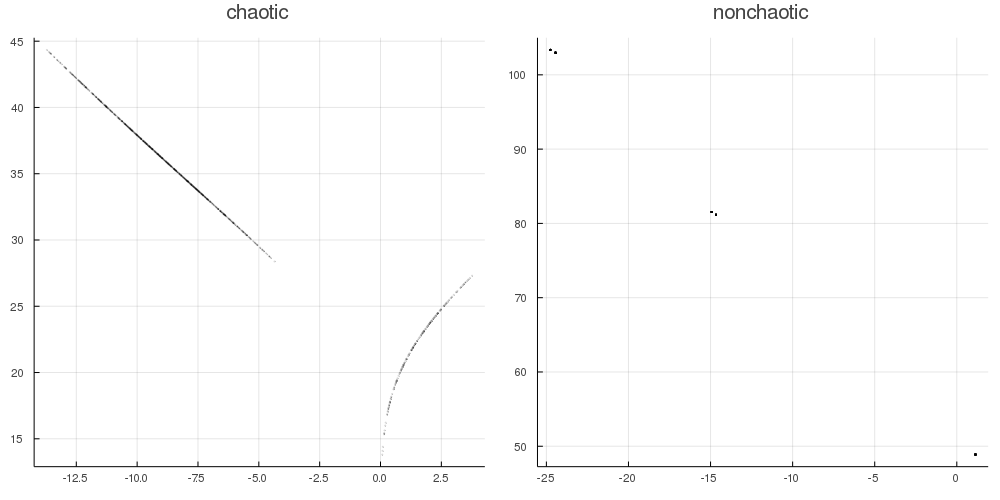

In [20]:
p1 = scatter(psos_chaotic[:, 1], psos_chaotic[:, 3],
        markersize=0.15, markeralpha = 0.15, markercolor=:black,
        leg=false, title="chaotic", 
        html_output_format=:png)

p2 = scatter(psos_regular[:, 1], psos_regular[:, 3],
        markersize=0.15, markeralpha = 0.15, markercolor=:black,
        leg=false, title="nonchaotic", 
        html_output_format=:png)

plot(p1,p2,layout=(1,2),legend=false, size=(1000,500))

# 2.C. Lyapunov exponents

## Definition
Lyapunov exponents measure the exponential separation rate of trajectories that are (initially) close. 

Consider the following picture, where two nearby trajectories are evolved in time:
 

<img src="lyapunov.png" alt="Sketch of the Lyapunov exponent" style="width: 500px;"/>


* $\lambda$ denotes the "maximum Lyapunov exponent".
* A $D$-dimensional system has $D$ exponents.
* In general, a trajectory is called "chaotic" if
    1. it follows nonlinear dynamics
    2. it is *bounded* (does not escape to infinity)
    2. it has at least one positive Lyapunov exponent

*(please be aware that the above is an over-simplification! See the textbooks cited in our documentation for more)*

---

## Demonstration

Before computing Lyapunov exponents, we'll demonstrate the concept of exponential separation using the Henon map that we used before

$$
\begin{aligned}
x_{n+1} &= 1 - ax_n^2 + y_n \\
y_{n+1} &= bx_n
\end{aligned}
$$

In [21]:
henon = Systems.henon()

2-dimensional discrete dynamical system
 state:       [0.0, 0.0]
 e.o.m.:      hoop
 in-place?    false
 jacobian:    hoop_jac
 parameters:  [1.4, 0.3]

First we'll generate a trajectory for the towel map, `tr1`, from the default initial condition,

In [22]:
tr1 = trajectory(henon, 100)
summary(tr1)

"2-dimensional Dataset{Float64} with 101 points"

and then we will generate a second trajectory, `tr2`, with a starting point slightly shifted from the initial condition of `tr1`.

In [23]:
u2 = get_state(henon) + (1e-9 * ones(dimension(henon)))
tr2 = trajectory(henon, 100, u2)
summary(tr2)

"2-dimensional Dataset{Float64} with 101 points"

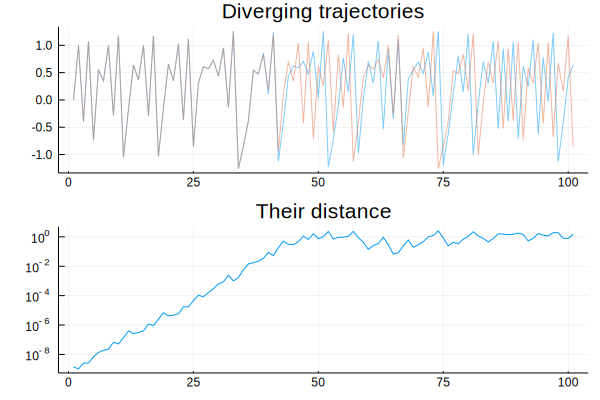

In [24]:
using LinearAlgebra: norm

# Plot the x-coordinate of the two trajectories:
p1 = plot(tr1[:, 1], alpha = 0.5, title="Diverging trajectories")
plot!(tr2[:, 1], alpha = 0.5)

# Plot their distance in a semilog plot:
d = [norm(tr1[i] - tr2[i]) for i in 1:length(tr2)]
p2 = plot(d, yaxis=:log, title="Their distance")

plot(p1,p2,layout=(2,1),legend=false)

### Computing the Lyapunov Exponents

`lyapunov` is a function that calculates the maximum Lyapunov exponent for a DynamicalSystem (for a given starting point).

In [25]:
λ = lyapunov(henon, 5000) # second argument is time to evolve

0.424089183372981

This number is _approximately_ the slope of the distance increase!



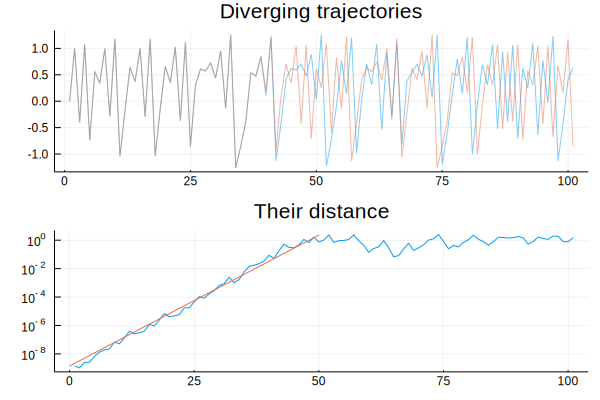

In [26]:
using LinearAlgebra: norm

p1 = plot(tr1[:, 1], alpha = 0.5, title="Diverging trajectories")
plot!(tr2[:, 1], alpha = 0.5)

d = [norm(tr1[i] - tr2[i]) for i in 1:length(tr2)]
p2 = plot(d, yaxis=:log, title="Their distance")
plot!(collect(0:50), d[1] .* exp.(collect(0:50) .* λ))

plot(p1,p2,layout=(2,1),legend=false)

If you want to get more than one Lyapunov exponents of a system, use `lyapunovs`

In [27]:
lyapunovs(henon, 2000)

2-element Array{Float64,1}:
  0.4217769280557995
 -1.6257497323817374

## Continuous systems

* All functions that accept a `DynamicalSystem` work with *any* instance of `DynamicalSystem`, regardless of whether it is continuous, discrete, in-place, out-of-place, with Jacobian or whatever.
* `lyapunov` and `lyapunovs` both accept a `DynamicalSystem`.

This means that they will "just work" if we use the Lorenz system, `lor`.


In [ ]:
lor = Systems.lorenz()
lyapunov(lor, 2000.0)

In [29]:
lyapunovs(lor, 2000)

3-element Array{Float64,1}:
   0.8953458807809997   
  -0.0001672331657737868
 -14.561821165638118    

    Remember from the Poincare section that for some parameter values the Lorenz system was periodic, for others it was not.

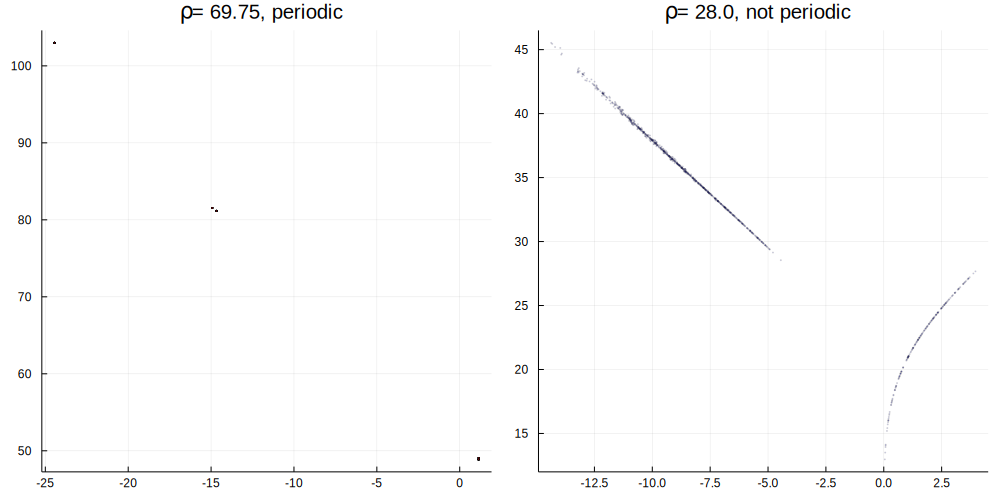

In [30]:
ρs = (69.75, 28.0)
p = []
c = ["red", "blue"]
for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    psos = poincaresos(lor, (2, 0.0), 2000.0, Ttr = 2000.0)
    pi = scatter(psos[:, 1], psos[:, 3],
        markersize=0.15, markeralpha = 0.15, markercolor=c[i], 
        title=string("\\rho", " = $ρ, ", (i != 1 ? "not periodic" : "periodic")))
    push!(p, pi)
end

plot(p[1],p[2],layout=(1,2),legend=false, size=(1000,500))

Seems like the exponent in the first case λ should be equal to zero, and in the second λ should be positive.

In [32]:
ρs = (69.75, 28.0)

for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    λ = lyapunov(lor, 2000.0; Ttr = 2000.0)
    println("For ρ = $ρ, λ = $λ")
end

For ρ = 69.75, λ = -0.00014990390240304403
For ρ = 28.0, λ = 0.9047748085497478


One has to be **very careful** when using functions like `lyapunovs`. They are approximative methods! Naively doing short computations or not using large transient times can lead to wrong results!

In [33]:
for (i, ρ) in enumerate(ρs)
    set_parameter!(lor, 2, ρ)
    λ = lyapunov(lor, 200.0) # smaller integration time, no transient time
    println("For ρ = $ρ, λ = $λ")
end

For ρ = 69.75, λ = 0.18490371491733312
For ρ = 28.0, λ = 0.7926460928213243


## Benchmarks

The Lyapunov exponent computations are quite fast! To benchmark them we can use the `BenchmarkTools` package.

In [3]:
using BenchmarkTools, OrdinaryDiffEq

In [4]:
diffeq = (reltol = 1e-6, abstol = 1e-6) 

(reltol = 1.0e-6, abstol = 1.0e-6)

In [5]:
@btime lyapunovs($lor, 2000; Ttr = 200, $diffeq...); # use default solver SimpleATsit5()

LoadError: UndefVarError: lor not defined

For performance it is always imprortant to choose the correct solver! For example, even though `Vern9()` is a higher order solver than the default, it is faster for computing the exponent:

In [37]:
@btime lyapunovs($lor, 2000; Ttr = 200, $diffeq..., alg = Vern9());

  23.921 ms (85 allocations: 14.16 KiB)


This happens because `Vern9` can take larger steps. For more information visit the official documentation of **DynamicalSystems.jl**.

---

Discrete systems are also super faster!

In [1]:
tow = Systems.towel() # 3D discrete chaotic system

LoadError: UndefVarError: Systems not defined

In [2]:
@btime lyapunovs($tow, 2000; Ttr = 200);

LoadError: LoadError: UndefVarError: @btime not defined
in expression starting at In[2]:1

In [40]:
@btime lyapunov($tow, 2000; Ttr = 200);

  39.600 μs (14 allocations: 1.14 KiB)


# 2.D. How **DynamicalSystems.jl** is a library

What if the command `lyapunov(ds, 2000)` is too magical for you? Given that you have a basic idea of what a Lyapunov exponent is, you still don't know _how_ the function `lyapunov` actually computes it.

And knowing _exactly_ how a function computes stuff is really important for science!

For this, we turn to its documentation string:

In [41]:
?lyapunov

search: lyapunov lyapunovs numericallyapunov



```
lyapunov(ds::DynamicalSystem, Τ; kwargs...) -> λ
```

Calculate the maximum Lyapunov exponent `λ` using a method due to Benettin [1], which simply evolves two neighboring trajectories (one called "given" and one called "test") while constantly rescaling the test one. `T`  denotes the total time of evolution (should be `Int` for discrete systems).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the trajectories before starting to measure the expontent. Should be `Int` for discrete systems.
  * `d0 = 1e-9` : Initial & rescaling distance between the two neighboring trajectories.
  * `upper_threshold = 1e-6` : Upper distance threshold for rescaling.
  * `lower_threshold = 1e-12` : Lower distance threshold for rescaling (in order to  be able to detect negative exponents).
  * `dt = 1` : Time of evolution between each check of distance exceeding the thresholds. For continuous systems this is approximate.
  * `inittest = (u1, d0) -> u1 .+ d0/sqrt(D)` : A function that given `(u1, d0)` initializes the test state with distance `d0` from the given state `u1` (`D` is the dimension of the system). This function can be used when you want to avoid the test state appearing in a region of the phase-space where it would have e.g. different energy or escape to infinity.
  * `diffeq...` : Keyword arguments propagated into `init` of DifferentialEquations.jl. See [`trajectory`](@ref) for examples. Only valid for continuous systems.

## Description

Two neighboring trajectories with initial distance `d0` are evolved in time. At time $t_i$ their distance $d(t_i)$ either exceeds the `upper_threshold`, or is lower than `lower_threshold`, which initializes a rescaling of the test trajectory back to having distance `d0` from the given one, while the rescaling keeps the difference vector along the maximal expansion/contraction direction: $u_2 \to u_1+(u_2−u_1)/(d(t_i)/d_0)$.

The maximum Lyapunov exponent is the average of the time-local Lyapunov exponents

$$
\lambda = \frac{1}{t_{n} - t_0}\sum_{i=1}^{n}
\ln\left( a_i \right),\quad a_i = \frac{d(t_{i})}{d_0}.
$$

## Performance Notes

This function uses a [`parallel_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the low level method that accepts an integrator, and `reinit!` it to new initial conditions. See the "advanced documentation" for info on the integrator object. The low level method is

```
lyapunov(pinteg, T, Ttr, dt, d0, ut, lt)
```

## References

[1] : G. Benettin *et al.*, Phys. Rev. A **14**, pp 2338 (1976)


---

**All** documentation strings of functions exported by **DynamicalSystems.jl** have this structure:

1. Call signature
2. Couple of sentences explanation of what the function does
2. Keyword argument listing
3. Scientific description of the algorithm used
4. References

This way not only you get the basic idea of how the function works, but if this is not enough for you and want to learn more, you can look at the references!

# 2.E. More library: the GALI algorithm

For this part we will simply visit the documentation page of **DynamicalSystems.jl** and use the search function.

https://juliadynamics.github.io/DynamicalSystems.jl/latest/